In [1]:
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
import csv
from scipy import signal
import os.path 
from os import listdir
from os.path import isfile, join
from scipy.signal import savgol_filter
import copy

In [2]:
#Funcion que hace una lista de los archivos de una carpeta
def ls(ruta = '.'):
    return [arch for arch in listdir(ruta) if isfile(join(ruta, arch))]
#correr ls('.')

In [177]:
lista_archivo = ls('.')

##### Diccionario

In [212]:
Lcil = {}
Ltot = {}
Masa = {}
Dm = {}
DM = {}
Dc = {}
Dmedio = {}

for i in lista_archivo[1:-2]:
    nro = int(i[6])
    Dc[nro] = float(i[28]+'.'+i[30:32])
    DM[nro] = float(i[35]+'.'+i[37:39])
    Dm[nro] = float(i[42]+'.'+i[44:46])
    Lcil[nro] = float(i[20:22]+'.'+i[23:25])
    Ltot[nro] = float(i[10:12]+'.'+i[13:15])
    Dmedio[nro] = (DM[nro]+Dm[nro])/2
#     Masa[nro] = float(i[4])

##### Funciones

In [5]:
def picosy(t,ym,nprc):
    #Cuentas para hallar la velocidad del Ym
    
    #resto recta
    gradient, intercept, r_value, p_value, std_err = stats.linregress(t,ym)
    nuevo = []
    for i,j in zip(t,ym):
        nuevo.append(j-gradient*i-intercept)
    #filtro
    nuevo2 = savgol_filter(nuevo, 51, 3)
    
    peakind = signal.find_peaks_cwt(nuevo2, np.arange(1,10),noise_perc=nprc)
    tpicos=[]
    ypicos=[]
    for j in peakind:
        tpicos.append(t[j])
        ypicos.append(ym[j])
    
    yperiod = []
    for i in range(len(tpicos)-1):
        yperiod.append(tpicos[i+1]-tpicos[i])
    return tpicos, ypicos, np.mean(yperiod)

In [6]:
def picosang(t,Ang,nprc):
    #filtro
    nuevo = savgol_filter(Ang, 51, 3)
    #busco picos
    peakind_Ang = signal.find_peaks_cwt(nuevo, np.arange(1,10),noise_perc=nprc)
    
    Ang_tpicos=[]
    Ang_picos=[]
    for j in peakind_Ang:
        Ang_tpicos.append(t[j])
        Ang_picos.append(Ang[j])

    Periodo_Ang = []
    for i in range(len(Ang_tpicos)-1):
        Periodo_Ang.append(Ang_tpicos[i+1]-Ang_tpicos[i])
    return Ang_tpicos, Ang_picos, np.mean(Periodo_Ang)

In [195]:
def analisis_de_cilindros(archivo,fps,Cal,cosa):
    
    with open(archivo, 'rt') as f:
        reader = csv.reader(f)
        data = list(reader)
        for row in reader:
            print(row)
 
    nro = int(archivo[6])
    
    a, b, n = cosa[0], cosa[1], cosa[2]
    
    tiempo = []
    Xm = []
    Ym = []
    ym = []
    Ang = []
    Angm = []
#     print(data[1][5]/Cal)
    for i in data[1:]:
        tiempo.append(float(i[0])/fps)
        Xm.append(float(i[1])/Cal)#-data[1][5]/Cal)
        Ym.append(float(i[2])/Cal)
        ym.append(-float(i[2])/Cal)
        Ang.append(float(i[5])-90)
        Angm.append(-(float(i[5])-90))
        
    #Correccion
    tiempo = tiempo[a:b] 
    Xm = Xm[a:b]
    Ym = Ym[a:b]
    ym = ym[a:b]
    Ang = Ang[a:b]
    Angm = Angm[a:b]
    
    #Calculo de la velocidad de sedimentacion del cilindro al descender verticalmente por la celda (vel de x centro de masa)          
    gradient, intercept, r_value, p_value, std_err = stats.linregress(tiempo,Xm)    

    tpicosM, ypicosM, Periodo_de_YM = picosy(tiempo,Ym,100) #Maximos
    tpicosm, ypicosm, Periodo_de_Ym= picosy(tiempo,ym,100) #Minimos
    ypicosm = -np.asarray(ypicosm)

    Ang_tpicosM, Ang_picosM, T_AngM = picosang(tiempo,Ang,100) #Maximos
    Ang_tpicosm, Ang_picosm, T_Angm = picosang(tiempo,Angm,100) #Minimos
    Ang_picosm = -np.asarray(Ang_picosm)
    
    Periodo_de_Y = (Periodo_de_YM+Periodo_de_Ym)/2
    T_Ang = (T_AngM+T_Angm)/2

    plt.figure(lista_archivo.index(archivo),figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(tiempo,Ym,label = 'Lcil = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.plot(tpicosM,ypicosM,'r*')
    plt.plot(tpicosm,ypicosm,'m*')
    plt.grid(b=True, which='major')
    plt.subplot(1,3,2)
    plt.plot(tiempo,Ang,label = 'L = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.plot(Ang_tpicosM,Ang_picosM,'r*')
    plt.plot(Ang_tpicosm,Ang_picosm,'m*')
    plt.grid(b=True, which='major')
    plt.subplot(1,3,3)
    plt.plot(tiempo,Xm,label = 'L = '+str(Lcil[nro])+', D = '+str(Dmedio[nro]))
    plt.grid(b=True, which='major')
    plt.legend()
    
    LaPapa = [nro,tiempo,Xm,Ym,Ang,tpicosM,ypicosM,tpicosm,ypicosm,Ang_tpicosM,Ang_picosM,Ang_tpicosm,Ang_picosm]
    #ERRORES
    #tiempo
#     errT = 1/fps
    
#     T4 = 0
#     T12 = 0
#     for i in yperiod:
#         T4 = i**(-4)+T4
#     for i in range(len(yperiod)-1):
#         T12 = -2/((yperiod[i]*yperiod[i+1])**2) + T12
#     errfy = (1/fps)*np.sqrt((T4+T12)/len(yperiod)) 
    
#     T4 = 0
#     T12 = 0
#     for i in Periodo_Ang:
#         T4 = i**(-4)+T4
#     for i in range(len(Periodo_Ang)-1):
#         T12 = -2/(Periodo_Ang[i]*Periodo_Ang[i+1]) + T12
#     errfa = (1/fps)*np.sqrt((T4+T12)/len(Periodo_Ang)) 
    
    return nro, gradient, Periodo_de_Y, T_Ang, LaPapa  
#     return L, D, gradient, std_err, Periodo_de_Y, errfy, T_Ang, errfa      

In [200]:
cosas = [[0,400,5],[0,300,5],[0,370,5],[7,360,3],[0,387,3],[0,420,3],[0,393,4],[0,380,12]]

1 -32.2229764503403 0.6405234711847938 1.0801603206412826
2 -34.081802551183884 1.0501002004008015 0.871743486973948
3 -35.77742221541903 0.6720106880427522 1.5686929414384323
4 -35.01267846449867 0.8510354041416166 0.8935728600057258
5 -34.10948589011469 0.9977097051245348 0.9527984540509591
6 -30.470670708952806 0.6493506493506493 0.8572700957470496
7 -34.32478779181489 1.120574482297929 1.02633839106785


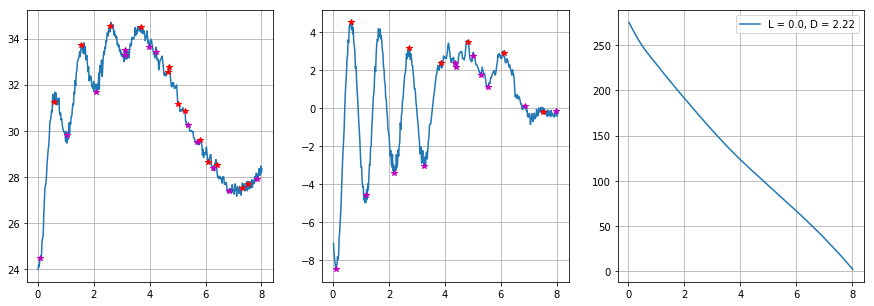

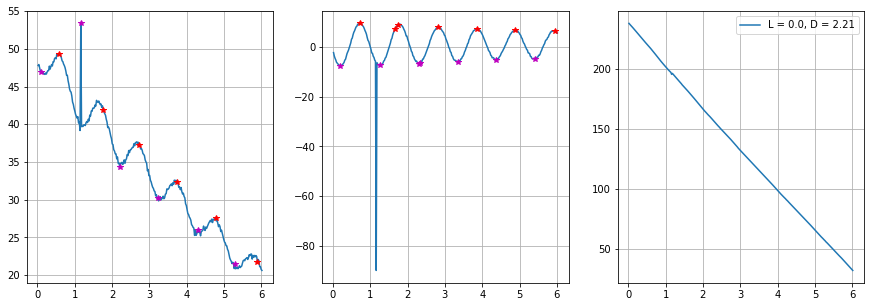

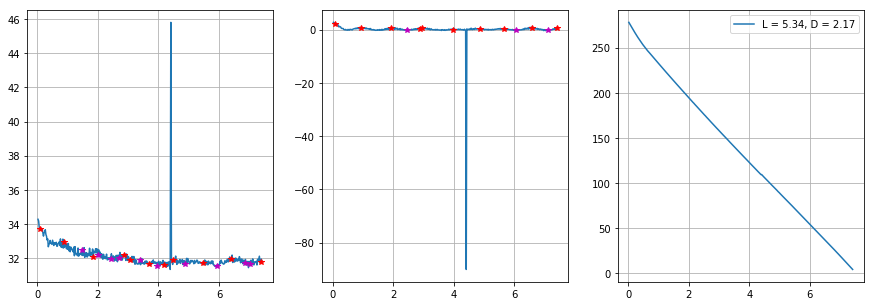

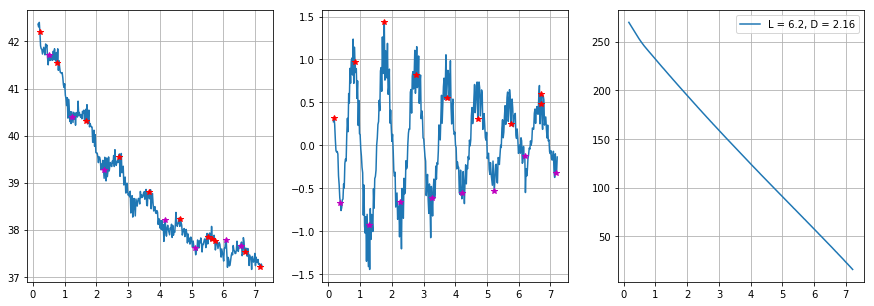

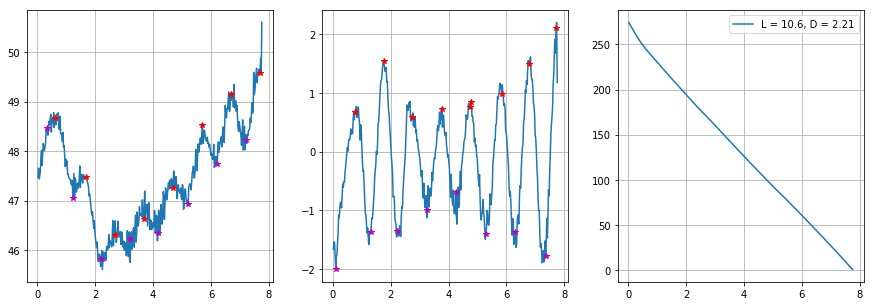

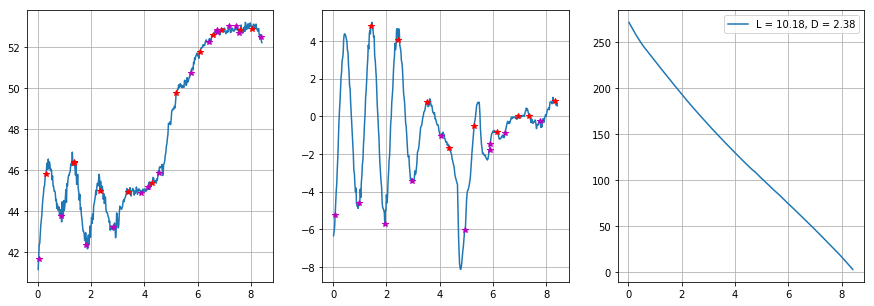

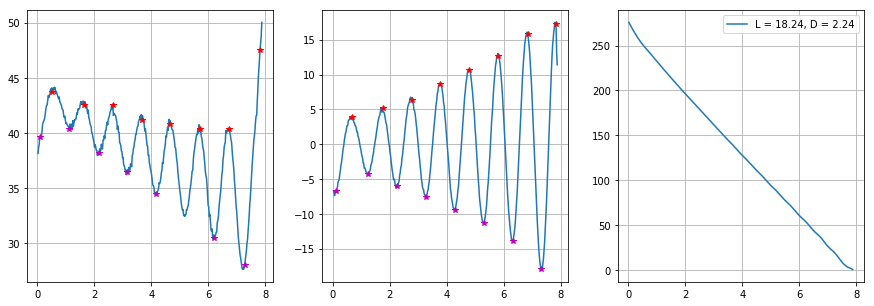

In [205]:
Discretos = []
MaximosY = {}
MinimosY = {}
MaximosA = {}
MinimosA = {}
tMaximosY = {}
tMinimosY = {}
tMaximosA = {}
tMinimosA = {}
Tiempo = {}
YCM = {}
XCM = {}
ANG = {}
VCM = {}
TY = {}
TA = {}
for i in range(1,8):
    nro, Vcm, Ty, Ta, dat = analisis_de_cilindros(lista_archivo[i],49.9,1,cosas[i-1])
    VCM[nro]=Vcm
    print(nro, Vcm, Ty, Ta)
    TY[nro]=Ty
    TA[nro]=Ta
    MaximosY[nro]=dat[6]
    tMaximosY[nro]=dat[5]
    MinimosY[nro]=dat[8]
    tMinimosY[nro]=dat[7]
    tMaximosA[nro] = dat[9]
    MaximosA[nro] = dat[10]
    tMinimosA[nro] = dat[11]
    MinimosA[nro] = dat[12]
    Tiempo[nro] = dat[1]
    YCM[nro] = dat[3]
    XCM[nro] = dat[2]
    ANG[nro] = dat[4]

### Correcciones

Largo Cilindro = 18.24 Largo total = 36.08 Diametro medio = 2.24


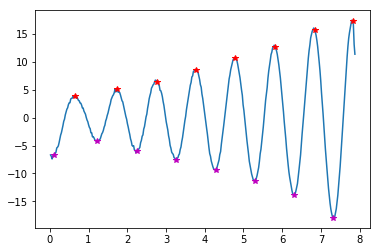

In [251]:
i=7
plt.plot(Tiempo[i],ANG[i])
plt.plot(tMaximosA[i],MaximosA[i],'*r')
plt.plot(tMinimosA[i],MinimosA[i],'*m')
# plt.ylim(-2,2)
# len(np.asarray(MaximosA[i])), len(np.asarray(MinimosA[i]))
print('Largo Cilindro = '+str(Lcil[i]), 'Largo total = '+str(Ltot[i]), 'Diametro medio = '+str(Dmedio[i]))

##### CilCon 1

In [263]:
frec=[]
t1=[]
for i in range(3):
    t1.append(tMinimosA[1][i+1]-tMinimosA[1][i])
TA[1]=np.mean(t1)
TA[1], Lcil[1]

(1.0487641950567803, 0.0)

##### CilCon2

In [262]:
frec=[]
t1=[tMinimosA[2][2]-tMinimosA[2][0]]
for i in range(3):
    t1.append(tMaximosA[2][i+1+2]-tMaximosA[2][i+2])
t2=[]
for i in range(2):
    t2.append(tMinimosA[2][i+1]-tMinimosA[2][i])
for i in range(3):
    t2.append(tMinimosA[2][i+1+3]-tMinimosA[2][i+3])
TA[2]=np.mean([np.mean(t1),np.mean(t2)])
TA[2], Lcil[2]

(1.1798597194388778, 0.0)

##### CilCon 3

In [261]:
frec=[]
t1=[tMaximosA[3][1]-tMaximosA[3][0],tMaximosA[3][3]-tMaximosA[3][1]]

TA[3]=np.mean(t1)
TA[3], Lcil[3]

(1.3927855711422845, 5.34)

##### CilCon 4

In [260]:
frec=[]
t1=[]
t2=[]
for i in range(6):
    t1.append(tMaximosA[4][i+1+1]-tMaximosA[4][i+1])
    t2.append(tMinimosA[4][i+1]-tMinimosA[4][i])
TA[4]=(np.mean(t1)+np.mean(t2))/2
TA[4], Lcil[4]

(0.9719438877755511, 6.2)

##### CilCon 5

In [259]:
t1=[tMaximosA[5][7]-tMaximosA[5][6],tMaximosA[5][6]-tMaximosA[5][5],tMinimosA[5][7]-tMinimosA[5][6],tMinimosA[5][6]-tMinimosA[5][5]]
TA[5]=np.mean(t1)
TA[5], Lcil[5]

(1.0170340681362726, 10.6)

##### CilCon 7

In [257]:
t1=[]
t2=[]
for i in range(len(tMaximosA[7][1:])-1):
    t1.append(tMaximosA[7][i+1]-tMaximosA[7][i])
    t2.append(tMinimosA[7][i+1+1]-tMinimosA[7][i+1])
TA[7]=(np.mean(t1)+np.mean(t2))/2
TA[7], Lcil[7]

(1.0220440881763526, 18.24)

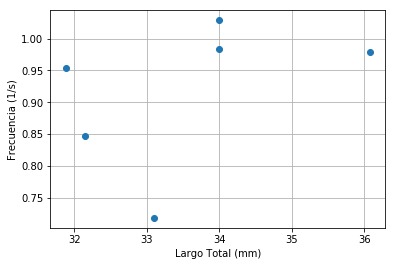

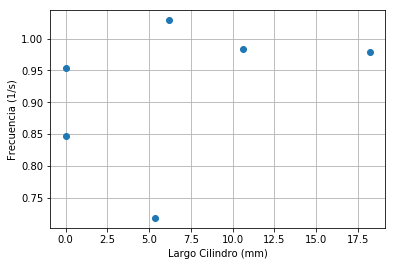

In [256]:
frecuenciasA = []
Lc = []
LT = []
for i in [1,2,3,4,5,7]:
    Lc.append(Lcil[i])
    LT.append(Ltot[i])
    frecuenciasA.append(1/TA[i])    

plt.figure(1)
plt.plot(LT,frecuenciasA,'o')
plt.xlabel('Largo Total (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')
plt.figure(2)
plt.plot(Lc,frecuenciasA,'o')
plt.xlabel('Largo Cilindro (mm)')
plt.ylabel('Frecuencia (1/s)')
plt.grid(b=True, which='major')

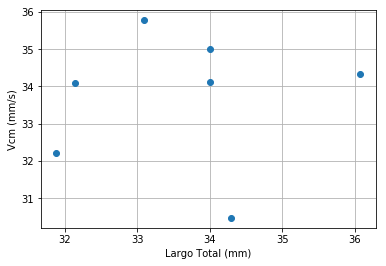

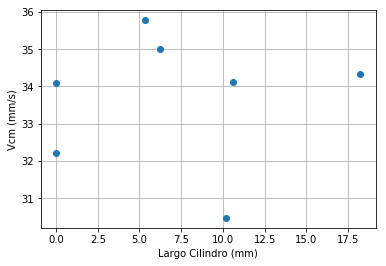

In [253]:
Velocidades=[]
LargosTot=[]
LargosCil=[]

for i in range(1,8):
    Velocidades.append(-np.asarray(VCM[i]))
    LargosTot.append(Ltot[i])
    LargosCil.append(Lcil[i])
plt.figure(1)
plt.plot(LargosTot,Velocidades,'o')
plt.xlabel('Largo Total (mm)')
plt.ylabel('Vcm (mm/s)')
plt.grid(b=True, which='major')
plt.figure(2)
plt.plot(LargosCil,Velocidades,'o')
plt.xlabel('Largo Cilindro (mm)')
plt.ylabel('Vcm (mm/s)')
plt.grid(b=True, which='major')